In [2]:
import torch
import os
import json
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import xml.etree.ElementTree as ET
import albumentations as A
import albumentations.pytorch.transforms as A_transform

from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16
from torchvision.ops import box_convert, box_iou, nms, clip_boxes_to_image

from tqdm import tqdm
from PIL import Image

import conf as cfg

In [2]:
def make_json_file(vocpath):
    abspath = os.path.abspath(vocpath, )

    for data_split in ['train', 'trainval', 'val']:
        with open(f"{abspath}/ImageSets/Main/{data_split}.txt", "r") as f:
            file_path_list = f.read().splitlines()
        
        img_path_list = [f"{abspath}/JPEGImages/{i}.jpg" for i in file_path_list]
        xml_path_list = [f"{abspath}/Annotations/{i}.xml" for i in file_path_list]
        xml_parse_list = []

        for single_xmlpath in xml_path_list:
            tree = ET.parse(single_xmlpath)
            root = tree.getroot()
            bbox_dict = {"boxes": [], "labels": []}

            for _object in root.findall("object"):
                label = cfg.CLASSES_DICT[_object.find("name").text]
                
                xmin = int(_object.find("bndbox").find("xmin").text) - 1
                ymin = int(_object.find("bndbox").find("ymin").text) - 1
                xmax = int(_object.find("bndbox").find("xmax").text) - 1
                ymax = int(_object.find("bndbox").find("ymax").text) - 1

                bbox_dict['boxes'].append([xmin, ymin, xmax, ymax])
                bbox_dict['labels'].append(label)                
            
            xml_parse_list.append(bbox_dict)

        with open(f"./pre_defined_data/{data_split}_images.json", "w") as f:
            json.dump(img_path_list, f)
        
        with open(f"./pre_defined_data/{data_split}_annot.json", "w") as f:
            json.dump(xml_parse_list, f)

class VOCDataset(Dataset):
    def __init__(self, data_split, img_resize, apply_transform):
        with open(f"./pre_defined_data/{data_split}_images.json", "r") as f:
            self.img_path_list = json.load(f)[:2]
        
        with open(f"./pre_defined_data/{data_split}_annot.json", "r") as f:
            self.xml_parse_list = json.load(f)[:2]
        
        self.transform = apply_transform
        self.imgwidth, self.imgheight = img_resize

    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, idx):
        gridinfo = torch.zeros((7, 7, 30), dtype=torch.float)

        img = np.array(Image.open(self.img_path_list[idx]))
        bbox = self.xml_parse_list[idx]['boxes']
        labels = self.xml_parse_list[idx]['labels']

        augmentation = self.transform(image=img, bboxes=bbox, class_labels=labels)

        img = augmentation['image']
        labels = torch.tensor(augmentation['class_labels'])
        
        boxes = torch.tensor(augmentation['bboxes'])
        boxes = box_convert(boxes, in_fmt='xyxy', out_fmt='cxcywh')

        for box, label in zip(boxes, labels):
            box = box.float()
            grid_x = int(box[0] / 32)
            grid_y = int(box[1] / 32)

            gridinfo[grid_x, grid_y, [0, 5]] = box[0] / self.imgwidth
            gridinfo[grid_x, grid_y, [2, 7]] = box[2] / self.imgwidth

            gridinfo[grid_x, grid_y, [1, 6]] = box[1] / self.imgheight
            gridinfo[grid_x, grid_y, [3, 8]] = box[3] / self.imgheight
                     
            gridinfo[grid_x, grid_y, [4, 9]] = 1
            gridinfo[grid_x][grid_y][10 + label] = 1

        return img, gridinfo

img_width, img_height = (224, 224)

A_resize = A.Compose([A.Resize(img_width, img_height),
                      A.Normalize(),
                      A_transform.ToTensorV2()
                      ],
                     bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

train_dataset = VOCDataset(data_split='trainval', img_resize=(img_width, img_height), apply_transform=A_resize)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=False, pin_memory=True)

In [3]:
class YOLOv1(nn.Module):
    def __init__(self):
        super(YOLOv1, self).__init__()

        self.backbone = vgg16(weights=True)

        if cfg.FREEZING:
            for param in self.backbone.features.parameters():
                param.requires_grad = False
        
        self.backbone = self.backbone.features[:-1]

        self.added_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(7* 7 * 1024, 4096),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 7 * 7 * 30),
            nn.Sigmoid() # cx, cy, w, h, confidence, class probabilities 모두 0~1 범위 내에 해당하므로
        )


        for layer in self.added_conv.modules():
    	    if isinstance(layer, nn.Conv2d):
		        nn.init.normal_(layer.weight, mean=0, std=0.01)
                  
        for layer in self.fc.modules():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0, std=0.01)

    def inference(self, pred, img_width, img_height, conf_thres=0.25, iou_thres=0.45):
        with torch.no_grad():
            coord_info = pred[:, :, :10]
            coord_info = coord_info.view(7, 7, 2, 5)

            grid_max_conf, _ = pred[:, :, [4, 9]].max(dim=2)
            coord_info = coord_info[pred[:, :, [4, 9]] == grid_max_conf.unsqueeze(-1)].view(7, 7, 5)

            conf_mask = coord_info[:, :, 4] >= conf_thres

            class_info = pred[:, :, 10:]
            class_info = class_info[conf_mask].view(-1, 20)
            coord_info = coord_info[conf_mask]

            after_nms = torch.zeros((coord_info.size(0), 6))

            anchor_coord = coord_info[:, :4]
            anchor_conf = coord_info[:, 4]
            grid_class = class_info.argmax(dim=1)

            nms_ind = nms(anchor_coord, anchor_conf, iou_threshold=iou_thres)

            after_nms[:, :4] = anchor_coord[nms_ind]
            after_nms[:, 4] = anchor_conf[nms_ind]
            after_nms[:, 5] = grid_class
            
            after_nms[:, [0, 2]] *= img_width
            after_nms[:, [1, 3]] *= img_height

        return after_nms
    
    def forward(self, x):
         out = self.backbone(x)
         out = self.added_conv(out)
         out = self.fc(out)
         out = out.view(-1, 7, 7, 30)

         return out

class YOLOv1Loss(nn.Module):
    def __init__(self):
        super(YOLOv1Loss, self).__init__()

    def forward(self, pred_tensor, target_tensor):
        """
        현재 no object, object loss와 같이 배치단위 처리가 필요없는 부분도 
        배치단위 처리하게 짜놔서 학습 시 속도저하 요인이 되는듯.

        coordinate regression 등 불가피한 부분은 배치단위 처리,
        나머지 부분은 벡터화를 통한 처리속도 개선을 목적으로 하기.
        """
        batch_size = pred_tensor.size(0)

        batch_obj_loss = torch.tensor(0).to(cfg.DEVICE)
        batch_coord_loss = torch.tensor(0).to(cfg.DEVICE)
        batch_cls_loss = torch.tensor(0).to(cfg.DEVICE)
        batch_loss = torch.tensor(0).to(cfg.DEVICE)

        for i in range(batch_size):            
            batch_target_tensor = target_tensor[i]
            batch_pred_tensor = pred_tensor[i].contiguous()
            
            noobj_mask = target_tensor[i, :, :, 4] == 0

            pred_noobj_info = batch_pred_tensor[noobj_mask].view(-1, 30)
            target_noobj_info = batch_target_tensor[noobj_mask].view(-1, 30)

            noobj_conf_mask = torch.ByteTensor(pred_noobj_info.size()).fill_(0).to(cfg.DEVICE)
            noobj_conf_mask[:, [4, 9]] = 1

            noobj_pred_conf = pred_noobj_info[noobj_conf_mask]
            noobj_target_conf = target_noobj_info[noobj_conf_mask]
            
            noobj_loss = F.mse_loss(noobj_pred_conf, noobj_target_conf, reduction='sum')
            # ----------------------------- no object loss end -----------------------------
            obj_mask = target_tensor[i, :, :, 4] > 0
            
            pred_obj_info = batch_pred_tensor[obj_mask].view(-1, 30)
            target_obj_info = batch_target_tensor[obj_mask].view(-1, 30)

            bbox_pred = pred_obj_info[:, :10].contiguous().view(-1, 5)
            bbox_target = target_obj_info[:, :10].contiguous().view(-1, 5)
            
            pred_coord_xyxy = box_convert(bbox_pred[:, :4], in_fmt='cxcywh', out_fmt='xyxy')
            target_coord_xyxy = box_convert(bbox_target[:, :4], in_fmt='cxcywh', out_fmt='xyxy')

            max_iou, _ = box_iou(pred_coord_xyxy, target_coord_xyxy).max(dim=0)

            coord_obj_mask = torch.BoolTensor((bbox_pred.size(0))).to(cfg.DEVICE)
            coord_obj_mask[max_iou != 0] = True

            pred_coord_cxcy = bbox_pred[:, :2][coord_obj_mask]
            pred_coord_wh = bbox_pred[:, 2:4][coord_obj_mask]
            target_coord_cxcy = bbox_target[:, :2][coord_obj_mask]
            target_coord_wh = bbox_target[:, 2:4][coord_obj_mask]

            coord_loss_cxcy = F.mse_loss(pred_coord_cxcy, target_coord_cxcy, reduction='sum')
            coord_loss_wh = F.mse_loss(torch.sqrt(pred_coord_wh), torch.sqrt(target_coord_wh), reduction='sum')
            # ----------------------------- coordinate loss end ----------------------------            
            pred_iou = bbox_pred[:, 4][coord_obj_mask]
            target_iou = bbox_target[:, 4][coord_obj_mask]

            obj_loss = F.mse_loss(pred_iou, target_iou, reduction='sum')       
            # ----------------------------- objectness loss end ----------------------------
            class_target = target_obj_info[:, 10:]
            class_pred = pred_obj_info[:, 10:]
            
            cls_loss = F.mse_loss(class_pred, class_target, reduction='sum')
            # --------------------------- classification loss end --------------------------
            batch_cls_loss = batch_cls_loss + cls_loss
            batch_obj_loss = batch_obj_loss + obj_loss + (noobj_loss * cfg.NOOBJ_LAMBDA)
            batch_coord_loss = batch_coord_loss + (coord_loss_cxcy + coord_loss_wh) * cfg.COORD_LAMBDA
            # ------------------------------- batch loss end ------------------------------

        batch_cls_loss = batch_cls_loss / batch_size
        batch_obj_loss = batch_obj_loss / batch_size
        batch_coord_loss = batch_coord_loss / batch_size

        batch_loss = batch_cls_loss + batch_obj_loss + batch_coord_loss

        return batch_loss, batch_cls_loss, batch_obj_loss, batch_coord_loss

In [4]:
m = YOLOv1().to(cfg.DEVICE)
criterion = YOLOv1Loss().to(cfg.DEVICE)

optimizer = torch.optim.SGD(m.parameters(), lr = 0.001, momentum = 0.9, weight_decay=0.0005)

In [5]:
epochs = 200

m.train()
for epoch in range(1, epochs+1):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    train_epoch_loss, train_epoch_cls_loss, train_epoch_obj_loss, train_epoch_box_loss = 0, 0, 0, 0

    for train_minibatch, (img, gridinfo) in enumerate(pbar):
        img = img.to(cfg.DEVICE)
        gridinfo = gridinfo.to(cfg.DEVICE)
        
        res = m(img)

        calc_loss, cls_loss, box_loss, reg_loss = criterion(res, gridinfo)
        
        optimizer.zero_grad()
        calc_loss.backward()
        optimizer.step()

        train_epoch_loss = (train_epoch_loss * train_minibatch + calc_loss.item()) / (train_minibatch + 1)
        train_epoch_cls_loss = (train_epoch_cls_loss * train_minibatch + cls_loss.item()) / (train_minibatch + 1)
        train_epoch_obj_loss = (train_epoch_obj_loss * train_minibatch + box_loss.item()) / (train_minibatch + 1)
        train_epoch_box_loss = (train_epoch_box_loss * train_minibatch+ reg_loss.item()) / (train_minibatch + 1)

        loss_status = f"Epoch: {epoch}/{epochs}\tcls loss: {train_epoch_cls_loss:.6f}\tobj loss: {train_epoch_obj_loss:.6}\tbox loss: {train_epoch_box_loss:.6f}\tbatch loss: {train_epoch_loss:.6f}"
        pbar.set_description_str(loss_status)
    
    print()

Epoch: 1/200	cls loss: 15.403872	box loss: 13.3973	reg loss: 6.559159	batch loss: 35.360317: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


Epoch: 2/200	cls loss: 12.287513	box loss: 12.1339	reg loss: 5.913241	batch loss: 30.334652: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s]


Epoch: 3/200	cls loss: 9.190514	box loss: 9.91573	reg loss: 2.761994	batch loss: 21.868237: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 4/200	cls loss: 4.298016	box loss: 5.46988	reg loss: 1.792591	batch loss: 11.560488: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 5/200	cls loss: 1.075403	box loss: 2.04225	reg loss: 4.190456	batch loss: 7.308106: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 6/200	cls loss: 0.481812	box loss: 0.861684	reg loss: 4.861570	batch loss: 6.205066: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 7/200	cls loss: 0.439061	box loss: 0.795432	reg loss: 4.149454	batch loss: 5.383946: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 8/200	cls loss: 0.026411	box loss: 0.304037	reg loss: 5.924582	batch loss: 6.255031: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch: 9/200	cls loss: 0.253792	box loss: 0.504591	reg loss: 7.098206	batch loss: 7.856588: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 10/200	cls loss: 0.106488	box loss: 2.35515	reg loss: 18.099018	batch loss: 20.560659: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch: 11/200	cls loss: 0.073686	box loss: 1.06601	reg loss: 13.076162	batch loss: 14.215861: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch: 12/200	cls loss: 0.091571	box loss: 1.19221	reg loss: 16.518595	batch loss: 17.802378: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch: 13/200	cls loss: 0.183570	box loss: 1.21539	reg loss: 21.240841	batch loss: 22.639799: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch: 14/200	cls loss: 0.125013	box loss: 1.49201	reg loss: 19.827345	batch loss: 21.444372: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 15/200	cls loss: 0.020198	box loss: 1.21876	reg loss: 19.221382	batch loss: 20.460339: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 16/200	cls loss: 0.108719	box loss: 0.937354	reg loss: 19.770967	batch loss: 20.817041: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 17/200	cls loss: 0.041259	box loss: 0.73013	reg loss: 20.216160	batch loss: 20.987549: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 18/200	cls loss: 0.143887	box loss: 0.680724	reg loss: 19.057619	batch loss: 19.882231: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 19/200	cls loss: 0.100544	box loss: 0.719582	reg loss: 18.211302	batch loss: 19.031427: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 20/200	cls loss: 0.455046	box loss: 0.720926	reg loss: 16.450134	batch loss: 17.626106: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 21/200	cls loss: 1.168856	box loss: 1.2067	reg loss: 13.223686	batch loss: 15.599241: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 22/200	cls loss: 1.724837	box loss: 1.31447	reg loss: 10.910538	batch loss: 13.949842: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 23/200	cls loss: 1.890413	box loss: 1.52136	reg loss: 8.891500	batch loss: 12.303277: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Epoch: 24/200	cls loss: 2.186286	box loss: 1.58201	reg loss: 6.258401	batch loss: 10.026699: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 25/200	cls loss: 1.900265	box loss: 1.49048	reg loss: 4.881260	batch loss: 8.272011: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 26/200	cls loss: 0.564627	box loss: 0.708088	reg loss: 3.491902	batch loss: 4.764617: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 27/200	cls loss: 0.145755	box loss: 0.304746	reg loss: 4.334942	batch loss: 4.785444: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 28/200	cls loss: 0.045043	box loss: 0.0999027	reg loss: 3.794304	batch loss: 3.939250: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 29/200	cls loss: 0.038543	box loss: 0.0785805	reg loss: 5.004526	batch loss: 5.121650: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 30/200	cls loss: 0.012409	box loss: 0.039348	reg loss: 3.715335	batch loss: 3.767092: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 31/200	cls loss: 0.063528	box loss: 0.0767436	reg loss: 5.645717	batch loss: 5.785989: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 32/200	cls loss: 0.016584	box loss: 0.0443827	reg loss: 4.118150	batch loss: 4.179117: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 33/200	cls loss: 0.065953	box loss: 0.113784	reg loss: 4.165986	batch loss: 4.345723: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Epoch: 34/200	cls loss: 0.146936	box loss: 0.197787	reg loss: 4.090895	batch loss: 4.435617: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 35/200	cls loss: 0.255751	box loss: 0.277911	reg loss: 2.372777	batch loss: 2.906439: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 36/200	cls loss: 0.406658	box loss: 0.463381	reg loss: 2.657909	batch loss: 3.527948: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 37/200	cls loss: 0.356868	box loss: 0.35429	reg loss: 2.317905	batch loss: 3.029062: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 38/200	cls loss: 0.283199	box loss: 0.285177	reg loss: 2.146926	batch loss: 2.715302: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch: 39/200	cls loss: 0.343604	box loss: 0.318665	reg loss: 2.515186	batch loss: 3.177455: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 40/200	cls loss: 0.257919	box loss: 0.278181	reg loss: 2.679737	batch loss: 3.215837: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 41/200	cls loss: 0.088177	box loss: 0.161902	reg loss: 3.163240	batch loss: 3.413319: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 42/200	cls loss: 0.223936	box loss: 0.225416	reg loss: 3.186229	batch loss: 3.635581: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 43/200	cls loss: 0.075953	box loss: 0.124377	reg loss: 2.616929	batch loss: 2.817259: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 44/200	cls loss: 0.266842	box loss: 0.317511	reg loss: 2.856858	batch loss: 3.441211: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 45/200	cls loss: 0.245070	box loss: 0.321048	reg loss: 2.582951	batch loss: 3.149069: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 46/200	cls loss: 0.321865	box loss: 0.419124	reg loss: 2.933226	batch loss: 3.674216: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 47/200	cls loss: 0.522531	box loss: 0.582924	reg loss: 2.257792	batch loss: 3.363246: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 48/200	cls loss: 0.118550	box loss: 0.213346	reg loss: 2.175918	batch loss: 2.507813: 100%|██████████| 1/1 [00:00<00:00, 21.05it/s]


Epoch: 49/200	cls loss: 0.080503	box loss: 0.153714	reg loss: 2.189706	batch loss: 2.423923: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 50/200	cls loss: 0.075423	box loss: 0.170411	reg loss: 2.233778	batch loss: 2.479613: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch: 51/200	cls loss: 0.107015	box loss: 0.173492	reg loss: 1.811160	batch loss: 2.091667: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch: 52/200	cls loss: 0.054795	box loss: 0.104965	reg loss: 2.899426	batch loss: 3.059186: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 53/200	cls loss: 0.041697	box loss: 0.0884122	reg loss: 2.222957	batch loss: 2.353066: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 54/200	cls loss: 0.153378	box loss: 0.256582	reg loss: 1.957703	batch loss: 2.367662: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 55/200	cls loss: 0.104410	box loss: 0.190974	reg loss: 2.569665	batch loss: 2.865049: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 56/200	cls loss: 0.109907	box loss: 0.213211	reg loss: 1.901193	batch loss: 2.224311: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 57/200	cls loss: 0.147902	box loss: 0.255824	reg loss: 2.066272	batch loss: 2.469998: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 58/200	cls loss: 0.242588	box loss: 0.415116	reg loss: 1.792993	batch loss: 2.450696: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch: 59/200	cls loss: 0.201591	box loss: 0.215588	reg loss: 1.860314	batch loss: 2.277493: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch: 60/200	cls loss: 0.145842	box loss: 0.195435	reg loss: 1.954721	batch loss: 2.295998: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch: 61/200	cls loss: 0.207285	box loss: 0.240654	reg loss: 1.950510	batch loss: 2.398449: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 62/200	cls loss: 0.052023	box loss: 0.104926	reg loss: 1.982887	batch loss: 2.139836: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 63/200	cls loss: 0.024701	box loss: 0.0471095	reg loss: 3.163521	batch loss: 3.235332: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 64/200	cls loss: 0.048043	box loss: 0.0781197	reg loss: 2.666716	batch loss: 2.792879: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 65/200	cls loss: 0.039021	box loss: 0.0828241	reg loss: 1.895149	batch loss: 2.016994: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 66/200	cls loss: 0.129867	box loss: 0.158935	reg loss: 3.232700	batch loss: 3.521502: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 67/200	cls loss: 0.133609	box loss: 0.201405	reg loss: 2.182401	batch loss: 2.517414: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 68/200	cls loss: 0.451747	box loss: 0.505099	reg loss: 1.596019	batch loss: 2.552865: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch: 69/200	cls loss: 0.452896	box loss: 0.546228	reg loss: 1.824750	batch loss: 2.823875: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 70/200	cls loss: 0.451126	box loss: 0.512019	reg loss: 1.899544	batch loss: 2.862689: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 71/200	cls loss: 0.211915	box loss: 0.313208	reg loss: 1.664140	batch loss: 2.189263: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 72/200	cls loss: 0.088981	box loss: 0.119939	reg loss: 1.663175	batch loss: 1.872095: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 73/200	cls loss: 0.057723	box loss: 0.0876825	reg loss: 1.252034	batch loss: 1.397440: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


Epoch: 74/200	cls loss: 0.173280	box loss: 0.170697	reg loss: 1.731012	batch loss: 2.074988: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 75/200	cls loss: 0.050246	box loss: 0.0731765	reg loss: 1.737821	batch loss: 1.861243: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 76/200	cls loss: 0.051970	box loss: 0.0865934	reg loss: 2.278790	batch loss: 2.417353: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 77/200	cls loss: 0.047156	box loss: 0.0652403	reg loss: 1.565607	batch loss: 1.678004: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 78/200	cls loss: 0.094960	box loss: 0.123025	reg loss: 1.378095	batch loss: 1.596080: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 79/200	cls loss: 0.160305	box loss: 0.165548	reg loss: 1.056044	batch loss: 1.381898: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Epoch: 80/200	cls loss: 0.212806	box loss: 0.207256	reg loss: 1.476930	batch loss: 1.896991: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 81/200	cls loss: 0.205506	box loss: 0.225846	reg loss: 2.038132	batch loss: 2.469483: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 82/200	cls loss: 0.179047	box loss: 0.210517	reg loss: 1.677583	batch loss: 2.067147: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 83/200	cls loss: 0.151291	box loss: 0.164963	reg loss: 1.259868	batch loss: 1.576122: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 84/200	cls loss: 0.074424	box loss: 0.101219	reg loss: 1.880929	batch loss: 2.056572: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 85/200	cls loss: 0.051343	box loss: 0.081685	reg loss: 1.657477	batch loss: 1.790505: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 86/200	cls loss: 0.072696	box loss: 0.113785	reg loss: 1.137911	batch loss: 1.324392: 100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


Epoch: 87/200	cls loss: 0.054314	box loss: 0.0896224	reg loss: 1.839842	batch loss: 1.983778: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 88/200	cls loss: 0.058722	box loss: 0.1166	reg loss: 1.356108	batch loss: 1.531430: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 89/200	cls loss: 0.068853	box loss: 0.121021	reg loss: 1.645917	batch loss: 1.835791: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 90/200	cls loss: 0.108215	box loss: 0.185657	reg loss: 1.241101	batch loss: 1.534973: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 91/200	cls loss: 0.144298	box loss: 0.263187	reg loss: 0.876101	batch loss: 1.283585: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 92/200	cls loss: 0.148504	box loss: 0.208564	reg loss: 1.503860	batch loss: 1.860928: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 93/200	cls loss: 0.106593	box loss: 0.214265	reg loss: 1.295649	batch loss: 1.616507: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 94/200	cls loss: 0.085176	box loss: 0.177357	reg loss: 1.033357	batch loss: 1.295891: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 95/200	cls loss: 0.162288	box loss: 0.275206	reg loss: 1.380939	batch loss: 1.818433: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 96/200	cls loss: 0.118917	box loss: 0.194797	reg loss: 1.330441	batch loss: 1.644155: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 97/200	cls loss: 0.083974	box loss: 0.115561	reg loss: 1.046630	batch loss: 1.246166: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 98/200	cls loss: 0.051240	box loss: 0.0665841	reg loss: 1.383101	batch loss: 1.500926: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 99/200	cls loss: 0.060842	box loss: 0.0674881	reg loss: 1.441370	batch loss: 1.569700: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 100/200	cls loss: 0.042883	box loss: 0.0550057	reg loss: 1.614182	batch loss: 1.712071: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 101/200	cls loss: 0.074185	box loss: 0.0847978	reg loss: 1.338894	batch loss: 1.497877: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 102/200	cls loss: 0.079503	box loss: 0.0944733	reg loss: 1.048591	batch loss: 1.222567: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 103/200	cls loss: 0.080647	box loss: 0.112563	reg loss: 1.307847	batch loss: 1.501057: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 104/200	cls loss: 0.085144	box loss: 0.0758385	reg loss: 1.734247	batch loss: 1.895230: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch: 105/200	cls loss: 0.122692	box loss: 0.1409	reg loss: 1.365296	batch loss: 1.628888: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 106/200	cls loss: 0.131413	box loss: 0.129854	reg loss: 1.203498	batch loss: 1.464764: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 107/200	cls loss: 0.043444	box loss: 0.0732946	reg loss: 1.084166	batch loss: 1.200904: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 108/200	cls loss: 0.126557	box loss: 0.136263	reg loss: 1.520179	batch loss: 1.782999: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 109/200	cls loss: 0.089424	box loss: 0.099678	reg loss: 2.618554	batch loss: 2.807655: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 110/200	cls loss: 0.115595	box loss: 0.132601	reg loss: 0.928051	batch loss: 1.176248: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 111/200	cls loss: 0.107630	box loss: 0.154578	reg loss: 1.167212	batch loss: 1.429420: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 112/200	cls loss: 0.130409	box loss: 0.20033	reg loss: 1.065358	batch loss: 1.396098: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 113/200	cls loss: 0.090627	box loss: 0.176936	reg loss: 1.090711	batch loss: 1.358274: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 114/200	cls loss: 0.119888	box loss: 0.18338	reg loss: 1.116987	batch loss: 1.420255: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch: 115/200	cls loss: 0.109546	box loss: 0.217051	reg loss: 1.300374	batch loss: 1.626971: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 116/200	cls loss: 0.075444	box loss: 0.157952	reg loss: 1.102376	batch loss: 1.335772: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 117/200	cls loss: 0.156283	box loss: 0.249167	reg loss: 1.571324	batch loss: 1.976774: 100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


Epoch: 118/200	cls loss: 0.101596	box loss: 0.209443	reg loss: 0.784896	batch loss: 1.095935: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 119/200	cls loss: 0.142510	box loss: 0.199733	reg loss: 0.805500	batch loss: 1.147742: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 120/200	cls loss: 0.126082	box loss: 0.176017	reg loss: 0.891747	batch loss: 1.193846: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s]


Epoch: 121/200	cls loss: 0.078099	box loss: 0.163299	reg loss: 1.178647	batch loss: 1.420046: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 122/200	cls loss: 0.069255	box loss: 0.122351	reg loss: 1.310967	batch loss: 1.502573: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 123/200	cls loss: 0.058677	box loss: 0.101227	reg loss: 1.332005	batch loss: 1.491908: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 124/200	cls loss: 0.118061	box loss: 0.135702	reg loss: 1.882547	batch loss: 2.136310: 100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


Epoch: 125/200	cls loss: 0.071217	box loss: 0.102573	reg loss: 0.842950	batch loss: 1.016740: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 126/200	cls loss: 0.080590	box loss: 0.0872514	reg loss: 1.554020	batch loss: 1.721862: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 127/200	cls loss: 0.116392	box loss: 0.120152	reg loss: 0.901542	batch loss: 1.138085: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s]


Epoch: 128/200	cls loss: 0.080769	box loss: 0.105665	reg loss: 1.410460	batch loss: 1.596894: 100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


Epoch: 129/200	cls loss: 0.157926	box loss: 0.13934	reg loss: 1.326614	batch loss: 1.623880: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 130/200	cls loss: 0.116034	box loss: 0.138482	reg loss: 1.498651	batch loss: 1.753167: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 131/200	cls loss: 0.141426	box loss: 0.169538	reg loss: 0.923316	batch loss: 1.234280: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 132/200	cls loss: 0.135289	box loss: 0.124418	reg loss: 1.128803	batch loss: 1.388510: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 133/200	cls loss: 0.125707	box loss: 0.124249	reg loss: 0.721528	batch loss: 0.971484: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 134/200	cls loss: 0.040807	box loss: 0.0734844	reg loss: 1.094626	batch loss: 1.208917: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 135/200	cls loss: 0.082966	box loss: 0.111268	reg loss: 1.200474	batch loss: 1.394709: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 136/200	cls loss: 0.054759	box loss: 0.0731959	reg loss: 0.799322	batch loss: 0.927277: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 137/200	cls loss: 0.073116	box loss: 0.121902	reg loss: 1.500399	batch loss: 1.695416: 100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


Epoch: 138/200	cls loss: 0.082006	box loss: 0.162167	reg loss: 1.019897	batch loss: 1.264070: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 139/200	cls loss: 0.066385	box loss: 0.105716	reg loss: 1.194753	batch loss: 1.366853: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 140/200	cls loss: 0.048450	box loss: 0.121837	reg loss: 1.156045	batch loss: 1.326332: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 141/200	cls loss: 0.068501	box loss: 0.143755	reg loss: 0.955419	batch loss: 1.167676: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch: 142/200	cls loss: 0.149015	box loss: 0.239284	reg loss: 1.050056	batch loss: 1.438355: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 143/200	cls loss: 0.115669	box loss: 0.185738	reg loss: 0.619557	batch loss: 0.920963: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 144/200	cls loss: 0.064382	box loss: 0.0984225	reg loss: 1.005283	batch loss: 1.168087: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 145/200	cls loss: 0.098198	box loss: 0.118473	reg loss: 0.911242	batch loss: 1.127913: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch: 146/200	cls loss: 0.061310	box loss: 0.115985	reg loss: 0.928769	batch loss: 1.106065: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 147/200	cls loss: 0.063221	box loss: 0.0737208	reg loss: 0.865727	batch loss: 1.002669: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 148/200	cls loss: 0.066750	box loss: 0.0945909	reg loss: 0.812374	batch loss: 0.973714: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 149/200	cls loss: 0.081887	box loss: 0.0864614	reg loss: 0.808889	batch loss: 0.977237: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 150/200	cls loss: 0.100616	box loss: 0.101457	reg loss: 1.237950	batch loss: 1.440023: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 151/200	cls loss: 0.065907	box loss: 0.0690974	reg loss: 2.096765	batch loss: 2.231770: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch: 152/200	cls loss: 0.032456	box loss: 0.0533549	reg loss: 1.065249	batch loss: 1.151060: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Epoch: 153/200	cls loss: 0.103329	box loss: 0.104622	reg loss: 1.169022	batch loss: 1.376972: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 154/200	cls loss: 0.152216	box loss: 0.148131	reg loss: 0.852574	batch loss: 1.152922: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 155/200	cls loss: 0.088335	box loss: 0.119233	reg loss: 0.881590	batch loss: 1.089158: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 156/200	cls loss: 0.076051	box loss: 0.116733	reg loss: 0.885181	batch loss: 1.077965: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


Epoch: 157/200	cls loss: 0.093040	box loss: 0.15487	reg loss: 0.985810	batch loss: 1.233720: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 158/200	cls loss: 0.064353	box loss: 0.153935	reg loss: 0.871107	batch loss: 1.089395: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Epoch: 159/200	cls loss: 0.058884	box loss: 0.12731	reg loss: 0.927487	batch loss: 1.113681: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 160/200	cls loss: 0.111914	box loss: 0.160692	reg loss: 0.834245	batch loss: 1.106850: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 161/200	cls loss: 0.076311	box loss: 0.153524	reg loss: 0.699387	batch loss: 0.929222: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 162/200	cls loss: 0.070122	box loss: 0.141927	reg loss: 0.724487	batch loss: 0.936537: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 163/200	cls loss: 0.113413	box loss: 0.201875	reg loss: 0.886477	batch loss: 1.201765: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 164/200	cls loss: 0.102836	box loss: 0.167449	reg loss: 0.655255	batch loss: 0.925539: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Epoch: 165/200	cls loss: 0.094174	box loss: 0.151366	reg loss: 0.631760	batch loss: 0.877299: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 166/200	cls loss: 0.065859	box loss: 0.102032	reg loss: 0.614793	batch loss: 0.782684: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 167/200	cls loss: 0.256253	box loss: 0.267866	reg loss: 0.682450	batch loss: 1.206569: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 168/200	cls loss: 0.154841	box loss: 0.138942	reg loss: 0.599797	batch loss: 0.893580: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 169/200	cls loss: 0.058121	box loss: 0.0638202	reg loss: 0.643269	batch loss: 0.765210: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 170/200	cls loss: 0.048647	box loss: 0.0562057	reg loss: 0.829864	batch loss: 0.934717: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 171/200	cls loss: 0.048220	box loss: 0.0685383	reg loss: 0.776122	batch loss: 0.892881: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 172/200	cls loss: 0.041104	box loss: 0.0567996	reg loss: 0.665888	batch loss: 0.763792: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 173/200	cls loss: 0.048332	box loss: 0.0888019	reg loss: 0.732893	batch loss: 0.870027: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 174/200	cls loss: 0.039754	box loss: 0.0595931	reg loss: 0.766973	batch loss: 0.866320: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 175/200	cls loss: 0.055733	box loss: 0.0920108	reg loss: 0.811047	batch loss: 0.958791: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 176/200	cls loss: 0.069846	box loss: 0.13351	reg loss: 0.783330	batch loss: 0.986686: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 177/200	cls loss: 0.139461	box loss: 0.160637	reg loss: 0.892989	batch loss: 1.193088: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 178/200	cls loss: 0.059694	box loss: 0.0814858	reg loss: 0.494515	batch loss: 0.635694: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 179/200	cls loss: 0.080169	box loss: 0.109576	reg loss: 0.828272	batch loss: 1.018016: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 180/200	cls loss: 0.066148	box loss: 0.0963192	reg loss: 0.774164	batch loss: 0.936631: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 181/200	cls loss: 0.085181	box loss: 0.104526	reg loss: 0.583281	batch loss: 0.772989: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 182/200	cls loss: 0.068007	box loss: 0.0852065	reg loss: 0.587313	batch loss: 0.740527: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 183/200	cls loss: 0.065146	box loss: 0.0965171	reg loss: 0.561585	batch loss: 0.723249: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 184/200	cls loss: 0.093262	box loss: 0.123671	reg loss: 0.470510	batch loss: 0.687443: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 185/200	cls loss: 0.086599	box loss: 0.126105	reg loss: 0.807946	batch loss: 1.020649: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 186/200	cls loss: 0.109294	box loss: 0.132282	reg loss: 0.581938	batch loss: 0.823514: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 187/200	cls loss: 0.045446	box loss: 0.0906252	reg loss: 0.853943	batch loss: 0.990014: 100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


Epoch: 188/200	cls loss: 0.043615	box loss: 0.0992393	reg loss: 0.617586	batch loss: 0.760441: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch: 189/200	cls loss: 0.042881	box loss: 0.0988105	reg loss: 1.135751	batch loss: 1.277442: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 190/200	cls loss: 0.076034	box loss: 0.142613	reg loss: 0.639369	batch loss: 0.858016: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch: 191/200	cls loss: 0.053521	box loss: 0.0986094	reg loss: 0.590676	batch loss: 0.742806: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 192/200	cls loss: 0.088459	box loss: 0.168383	reg loss: 0.358407	batch loss: 0.615249: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 193/200	cls loss: 0.144111	box loss: 0.183966	reg loss: 0.651357	batch loss: 0.979434: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 194/200	cls loss: 0.092665	box loss: 0.160629	reg loss: 0.544793	batch loss: 0.798087: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch: 195/200	cls loss: 0.072564	box loss: 0.108759	reg loss: 0.734579	batch loss: 0.915901: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Epoch: 196/200	cls loss: 0.096577	box loss: 0.131132	reg loss: 0.237834	batch loss: 0.465543: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch: 197/200	cls loss: 0.049499	box loss: 0.0765486	reg loss: 0.465047	batch loss: 0.591095: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch: 198/200	cls loss: 0.141758	box loss: 0.143606	reg loss: 0.310451	batch loss: 0.595814: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Epoch: 199/200	cls loss: 0.074809	box loss: 0.0790646	reg loss: 0.712456	batch loss: 0.866329: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch: 200/200	cls loss: 0.075108	box loss: 0.072726	reg loss: 0.459142	batch loss: 0.606976: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]

[119.20536804199219, 111.66951751708984, 135.5998992919922, 138.76065063476562]
[92.90949249267578, 91.64190673828125, 125.78553009033203, 170.10934448242188]
[2.7996902465820312, 132.76205444335938, 45.547481536865234, 218.45941162109375]
[79.28658294677734, 139.6858673095703, 131.57626342773438, 220.22279357910156]
[121.596435546875, 117.95085144042969, 157.14620971679688, 209.90138244628906]


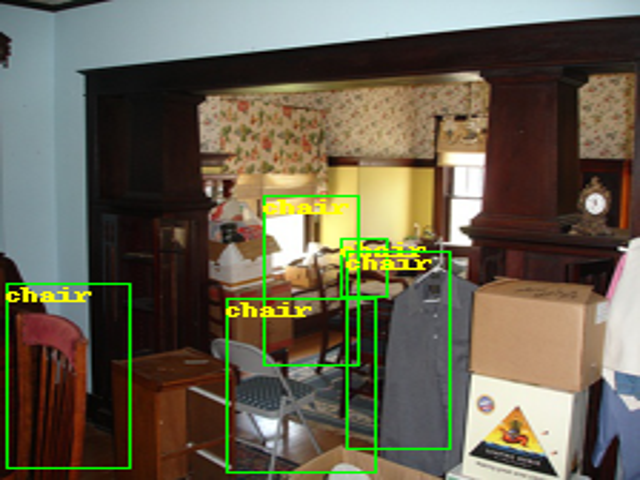

In [46]:
from PIL import Image, ImageDraw

m.eval()
A_inference = A.Compose([A.Resize(224, 224),
                         A.Normalize(),
                         A_transform.ToTensorV2()])

imgpath = 'path/of/image'
img = Image.open(imgpath)

img = img.resize((224, 224))
annot_image = ImageDraw.Draw(img)

def detect(img, transform_module, model):
    aug_img = np.array(img)
    aug_img = transform_module(image=aug_img)['image'].to(cfg.DEVICE)
    
    pred = model(aug_img.unsqueeze(0))
    res = model.inference(pred[0], 224, 224)
    pred = clip_boxes_to_image(res, size=(224, 224))
    
    bbox_pred = box_convert(pred[:, :4], in_fmt='cxcywh', out_fmt='xyxy')
    label_pred = [cfg.IDX2CLASSES[label] for label in pred[:, 5].tolist()]
    
    draw = ImageDraw.Draw(img)
    
    for bbox, label in zip(bbox_pred, label_pred):
        bbox = bbox.tolist()
        print(bbox)
        draw.rectangle(bbox, outline=(0, 255, 0))
        draw.text(bbox[:2], label, (255, 255, 0))

    return img

detect(img, A_inference, m).resize((640, 480))